In [1]:


import torch
from torch import nn
import numpy as np

from flow_matching.solver  import ODESolver
from flow_matching.utils import ModelWrapper
from flow_matching.path import CondOTProbPath
from flow_matching.path.scheduler import LinearVPScheduler

import matplotlib.pyplot as plt
import numpy as np
import imageio

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device=device)

In [3]:

def sample_checkerboard(batch_size):
    x1 = torch.rand(batch_size) * 4 - 2
  
    x2_ = torch.rand(batch_size) - torch.randint(0, 2, (batch_size,), dtype=torch.float) * 2
    x2 = (x2_ + (torch.floor(x1) % 2))
    
    data = (torch.stack([x1, x2], dim=1) * 2.0 )
    return data

def sample_source(batch_size):
    return torch.rand(batch_size, 2) * 8 - 4

In [4]:
class VectorFieldNetwork(nn.Module):
    def __init__(self, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(3, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.GELU(),
            nn.Linear(hidden_dim, 2)
        )

    def forward(self, x, t):
        t_embed = t.view(-1, 1).expand(x.shape[0], 1)
        x_input = torch.cat([x, t_embed], dim=1)
        return self.net(x_input)

In [5]:
flow  = ModelWrapper(VectorFieldNetwork())
batch = 4096

optimizer = torch.optim.Adam(flow.parameters(), lr = 1e-3)
loss_fn =  nn.MSELoss()

In [12]:
epochs = 40000

for _ in range(epochs):
    x_1 = sample_checkerboard(batch)
    x_0 = sample_source(batch)

    # print(x_1, x_0)

    path = CondOTProbPath()
    t = torch.rand(batch)
    path_sample = path.sample(x_0=x_0, x_1=x_1, t=t)
    # print(path_sample)
    # print(path.)
    x_t = path_sample.x_t
    d_t = path_sample.dx_t
    optimizer.zero_grad()
    v_pred = flow(x_t, t)
    loss = loss_fn(v_pred.flatten(), d_t.flatten())
    # print(loss)
    loss.backward()
    optimizer.step()
    if ( (_ + 1) % 100 == 0):
        print(f"Epoch {_ + 1}, Loss: {loss.item():.4f}")

Epoch 100, Loss: 7.8520
Epoch 200, Loss: 7.5694
Epoch 300, Loss: 7.4024
Epoch 400, Loss: 7.5844
Epoch 500, Loss: 7.5700
Epoch 600, Loss: 7.7766
Epoch 700, Loss: 7.6292
Epoch 800, Loss: 7.8319
Epoch 900, Loss: 7.5561
Epoch 1000, Loss: 7.6743
Epoch 1100, Loss: 7.7837
Epoch 1200, Loss: 7.9186
Epoch 1300, Loss: 7.6597
Epoch 1400, Loss: 7.7838
Epoch 1500, Loss: 7.7591
Epoch 1600, Loss: 7.5010
Epoch 1700, Loss: 7.8798
Epoch 1800, Loss: 7.6851
Epoch 1900, Loss: 7.7749
Epoch 2000, Loss: 7.6848
Epoch 2100, Loss: 7.7595
Epoch 2200, Loss: 7.7205
Epoch 2300, Loss: 7.9365
Epoch 2400, Loss: 7.6623
Epoch 2500, Loss: 7.7337
Epoch 2600, Loss: 7.7645
Epoch 2700, Loss: 7.6220
Epoch 2800, Loss: 7.6223
Epoch 2900, Loss: 7.6668
Epoch 3000, Loss: 7.6949
Epoch 3100, Loss: 7.5573
Epoch 3200, Loss: 7.6826
Epoch 3300, Loss: 7.7212
Epoch 3400, Loss: 7.8285
Epoch 3500, Loss: 7.6829
Epoch 3600, Loss: 7.6761
Epoch 3700, Loss: 7.4988
Epoch 3800, Loss: 7.5264
Epoch 3900, Loss: 7.7062
Epoch 4000, Loss: 7.7905
Epoch 410

In [24]:
steps = 100
time_grid = torch.linspace(0, 1, steps=steps)
time_grid

tensor([0.0000, 0.0101, 0.0202, 0.0303, 0.0404, 0.0505, 0.0606, 0.0707, 0.0808,
        0.0909, 0.1010, 0.1111, 0.1212, 0.1313, 0.1414, 0.1515, 0.1616, 0.1717,
        0.1818, 0.1919, 0.2020, 0.2121, 0.2222, 0.2323, 0.2424, 0.2525, 0.2626,
        0.2727, 0.2828, 0.2929, 0.3030, 0.3131, 0.3232, 0.3333, 0.3434, 0.3535,
        0.3636, 0.3737, 0.3838, 0.3939, 0.4040, 0.4141, 0.4242, 0.4343, 0.4444,
        0.4545, 0.4646, 0.4747, 0.4848, 0.4949, 0.5051, 0.5152, 0.5253, 0.5354,
        0.5455, 0.5556, 0.5657, 0.5758, 0.5859, 0.5960, 0.6061, 0.6162, 0.6263,
        0.6364, 0.6465, 0.6566, 0.6667, 0.6768, 0.6869, 0.6970, 0.7071, 0.7172,
        0.7273, 0.7374, 0.7475, 0.7576, 0.7677, 0.7778, 0.7879, 0.7980, 0.8081,
        0.8182, 0.8283, 0.8384, 0.8485, 0.8586, 0.8687, 0.8788, 0.8889, 0.8990,
        0.9091, 0.9192, 0.9293, 0.9394, 0.9495, 0.9596, 0.9697, 0.9798, 0.9899,
        1.0000], device='cuda:0')

In [25]:
x_0 = sample_source(1024)
# print(x_0)
solver = ODESolver(velocity_model=flow)
# steps = 1.0/256
results = solver.sample(x_0, step_size=1.0/steps,  time_grid=time_grid, return_intermediates=True)

print("Sampled x_1:", results[:-1])

Sampled x_1: tensor([[[-1.5380,  0.7838],
         [ 2.0652,  1.4340],
         [-2.9692,  2.5974],
         ...,
         [ 3.0226, -2.0477],
         [-0.7614, -0.4890],
         [ 3.1350,  1.1255]],

        [[-1.5231,  0.7766],
         [ 2.0453,  1.4202],
         [-2.9385,  2.5725],
         ...,
         [ 2.9913, -2.0272],
         [-0.7537, -0.4834],
         [ 3.1038,  1.1144]],

        [[-1.5081,  0.7695],
         [ 2.0253,  1.4065],
         [-2.9079,  2.5474],
         ...,
         [ 2.9600, -2.0066],
         [-0.7460, -0.4778],
         [ 3.0726,  1.1033]],

        ...,

        [[-2.0173,  0.6898],
         [ 1.8600,  1.6092],
         [-2.7018,  1.7676],
         ...,
         [ 2.6982, -1.5377],
         [-0.7527, -0.5954],
         [ 3.0893,  2.0553]],

        [[-2.0501,  0.6938],
         [ 1.8745,  1.6253],
         [-2.7311,  1.7801],
         ...,
         [ 2.7254, -1.5551],
         [-0.7597, -0.6024],
         [ 3.1255,  2.0844]],

        [[-2.0813,  0.6

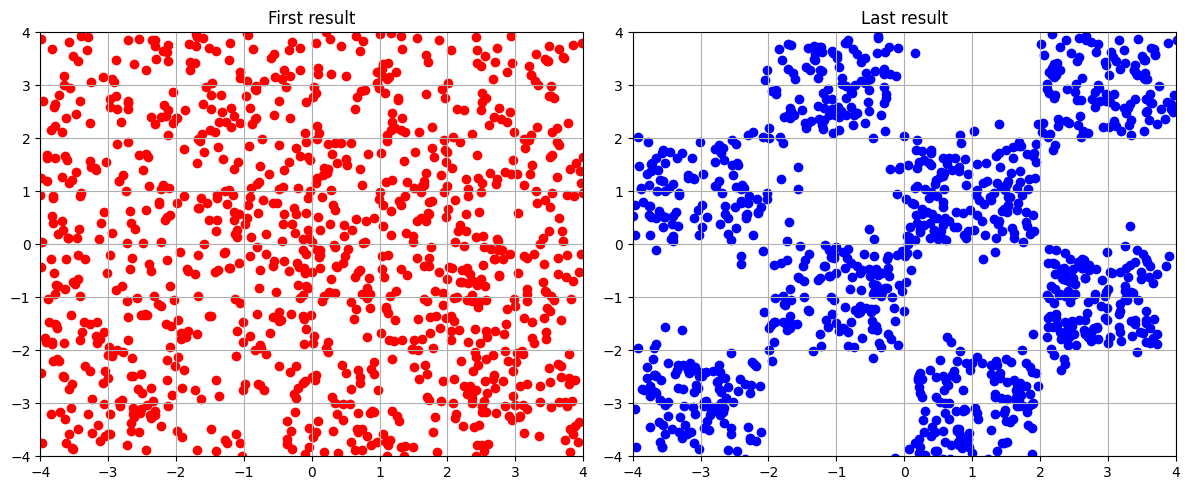

In [26]:
# Lấy result đầu tiên (giả sử là danh sách các điểm)
first_result = results[0]  # results[0] là list các điểm
last_result = results[-1]
# print(first_result)
# Nếu là tensor PyTorch


first_result_np = first_result.detach().cpu().numpy()
last_result_np = last_result.detach().cpu().numpy()

# Vẽ 2 hình cạnh nhau
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ----- First result -----
axes[0].scatter(first_result_np[:,0], first_result_np[:,1], color='red')
axes[0].set_title("First result")
axes[0].set_xlim([-4, 4])
axes[0].set_ylim([-4, 4])
axes[0].grid(True)

# ----- Last result -----
axes[1].scatter(last_result_np[:,0], last_result_np[:,1], color='blue')
axes[1].set_title("Last result")
axes[1].set_xlim([-4, 4])
axes[1].set_ylim([-4, 4])
axes[1].grid(True)

plt.tight_layout()
plt.show()

In [27]:
results_cpu_list = [r.detach().cpu().numpy() for r in results]
print(results_cpu_list[0])
frames = []

for i, results_cpu in enumerate(results_cpu_list):
    fig, ax = plt.subplots(figsize=(5,5))
    
    # Hiển thị toàn bộ batch tại thời điểm i
    ax.scatter(results_cpu[:,0], results_cpu[:,1], color='red', label=f'time step {i}')
    # ax.scatter(results_cpu[:,0], results_cpu[:,1], color='red', label=f'time step {i}')
    ax.legend()
    ax.set_title("ODE Sampling: Batch points over time")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.set_xlim([-4, 4])
    ax.set_ylim([-4, 4])
    
    # Lưu figure vào buffer
    fig.canvas.draw()
    w, h = fig.canvas.get_width_height()
    buf = np.frombuffer(fig.canvas.buffer_rgba(), dtype=np.uint8)
    image = buf.reshape((h, w, 4))  # 4 kênh RGBA
    frames.append(image)
    plt.close(fig)

# Tạo GIF
imageio.mimsave('ode_sampling_batch.gif', frames, duration=0.01)

[[-1.5379941   0.7837739 ]
 [ 2.0652442   1.4339871 ]
 [-2.9692485   2.5973973 ]
 ...
 [ 3.022635   -2.04769   ]
 [-0.76135445 -0.48900008]
 [ 3.1350236   1.1255388 ]]


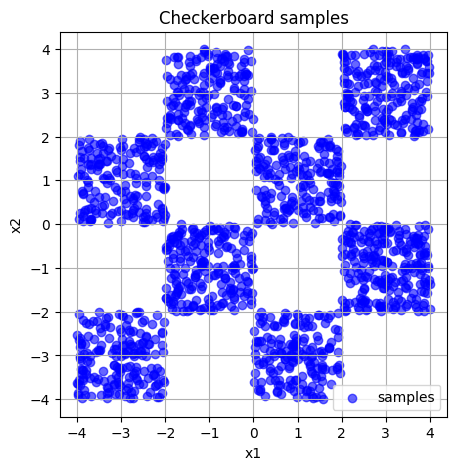

In [11]:
# Lấy dữ liệu
check_checker = sample_checkerboard(1500).cpu().numpy()  # shape [1000,2]

# Vẽ
plt.figure(figsize=(5,5))

# Chỉ cần scatter tất cả points
plt.scatter(check_checker[:,0], check_checker[:,1], color='blue', alpha=0.6, label='samples')

plt.title("Checkerboard samples")
plt.xlabel("x1")
plt.ylabel("x2")
plt.grid(True)
plt.legend()
plt.show()